In [1]:
#install the required libraries for the first time 
#!pip install skyfield
#!pip install tzwhere
#!pip install geopy

from datetime import datetime
# from geopy import Nominatim
from geopy.geocoders import Nominatim
from tzwhere import tzwhere
from pytz import timezone, utc

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Circle

from skyfield.api import Star, load, wgs84
from skyfield.data import hipparcos, mpc, stellarium
from skyfield.projections import build_stereographic_projection
from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN

# Εισαγωγικές έννοιες

 Για την περιγραφή αντικειμένων στην ουράνια σφαίρα χρειαζόμαστε 2 συντεταγμένες. Υπάρχουν πολλά διαφορετικά συστήματα συντεταγμένων που χρησιμοποιούνται σε αστρονομικές παρατηρήσεις. 

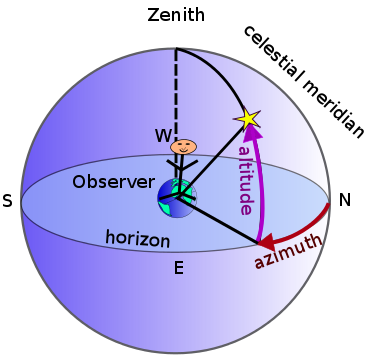

**Σχήμα 1. Τοπικό σύστημα συντεταγμένων (Horizontal coordinate system or Altitude-Azimuth coordinate system).** Αυτό το σύστημα συντεταγμένων είναι εμπνευσμένο από τη φαινόμενη κίνηση των άστρων στο νυχτερινό ουρανό από ένα συγκεκριμένο τόπο. Η περιγραφή ενός αντικειμένου στο νυχτερινό ουρανό γίνεται με 2 γωνίες που περιγράφουν τις οριζόντιες και κάθετες κινήσεις. Το υψόμετρο (altitude) αναφέρεται στο ύψος του αντικειμένου πάνω από τον ορίζοντα. Είναι γωνία που παίρνει τιμές από -90 μοίρες έως +90 μοίρες. Για παράδειγμα, αντικείμενα στον ορίζοντα έχουν  ύψος 0 μοίρες ενώ αντικείμενα παρατηρούμενα στην κατακόρυφο διεύθυνση έχουν ύψος 90 μοίρες ή -90 μοίρες (ζενίθ ή ναδίρ). Η άλλη συντεταγμένη ονομάζεται αζιμούθιο και αναφέρεται στη γωνία που μετράται στο οριζόντιο επίπεδο με δεξιόστροφη φορά ξεκινώντας από το Βορρά. Το αζιμούθιο είναι ίσο με 0 μοίρες στο Βορρά, 90 μοίρες στην Ανατολή κτλ. Το αζιμούθιο μπορεί να μετρηθεί και σε ώρες (0-24 hr). Το υψόμετρο και το αζιμούθιο ενός αντικειμένου μεταβάλλονται με το χρόνο (π.χ. αστέρες ανατέλλουν και δύουν στον ορίζοντα).

<!-- ![pre-flight-celestial-sphere.jpg](attachment:pre-flight-celestial-sphere.jpg) -->

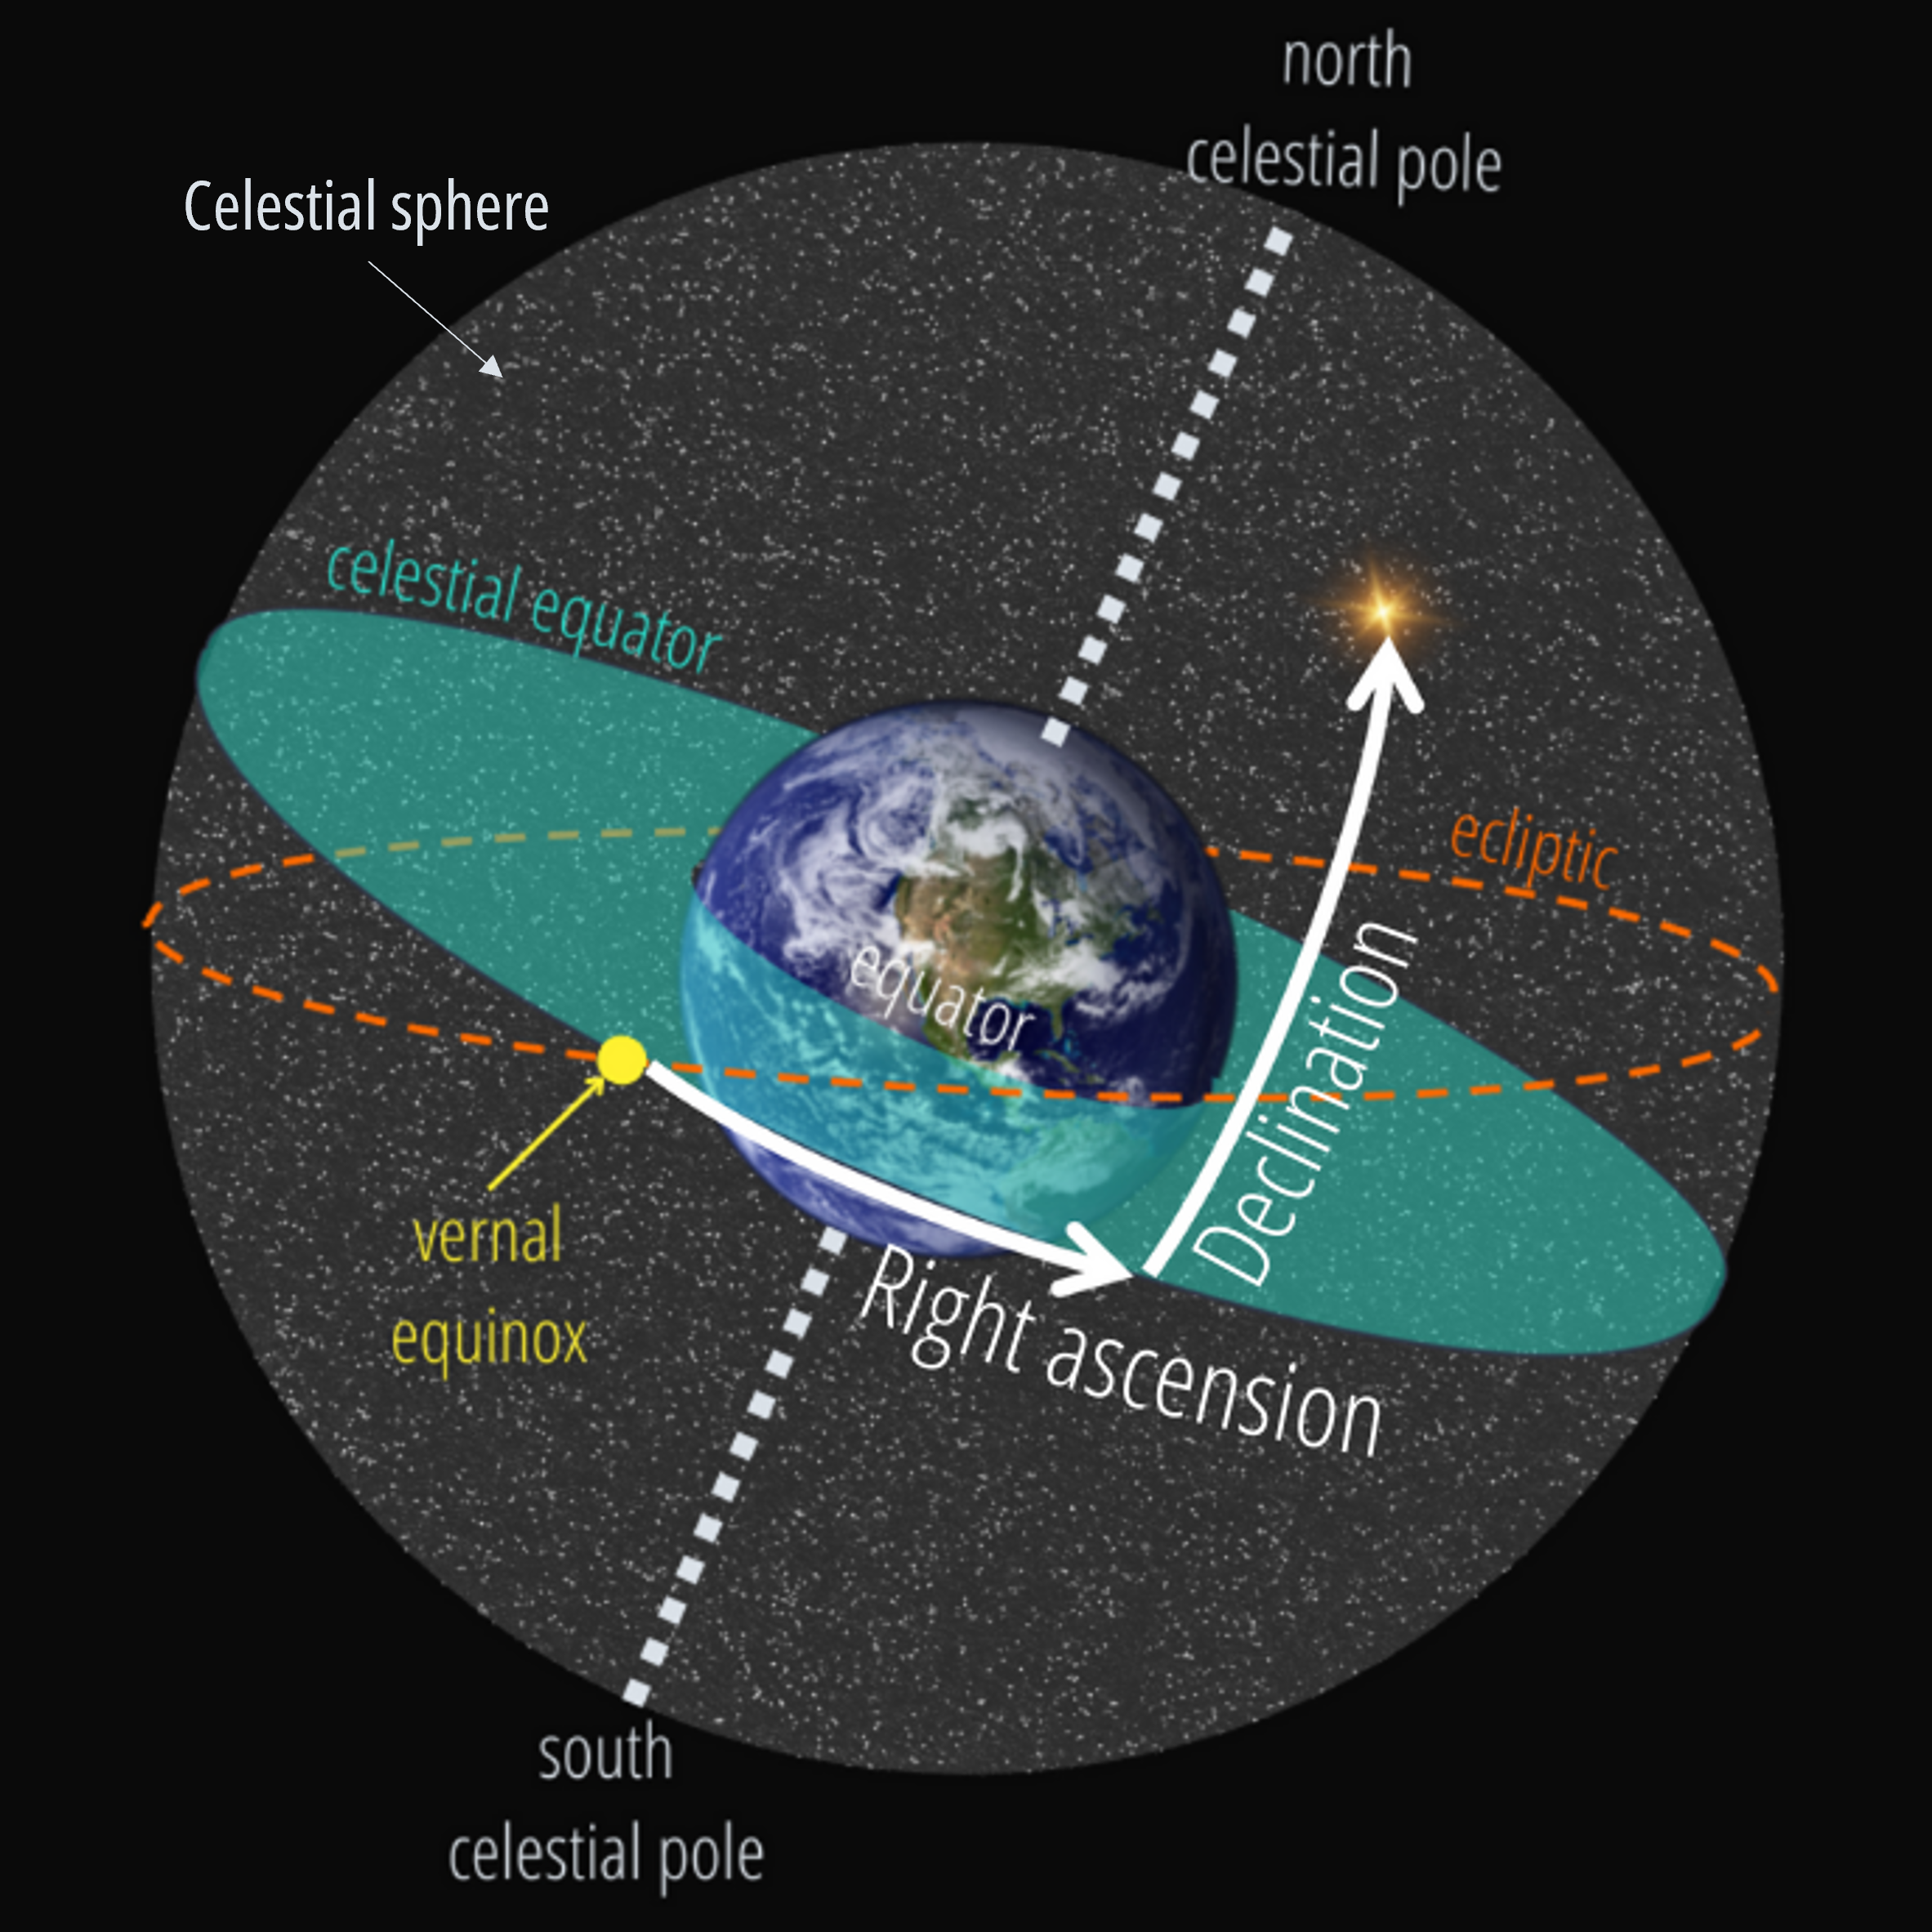

**Σχήμα 2. Σύστημα συντεταγμένων Ορθής αναφοράς - Απόκλισης (Right Ascension, Ra - Declination, Dec).**  Η Γη βρίσκεται στο κέντρο του συστήματος συντεταγμένων. Τα δύο επίπεδα αναφοράς είναι το ουράνιο ισημερινό επίπεδο (celestial equator) (φανταστείτε ένα άπειρο γήινο ισημερινό επίπεδο) και το επίπεδο της εκλειπτικής (τροχιακό επίπεδο κίνησης Γης γύρω από τον Ήλιο). Το επίπεδο της εκλειπτικής σχηματίζει 23.5 μοίρες με το ουράνιο ισημερινό επίπεδο. Το σημείο στο οποίο ο Ήλιος περνά από το ουράνιο ισημερινό επίπεδο ονομάζεται vernal equinox (εαρινή ισημερία). Λόγω της μετάπτωσης του άξονα περιστροφής της Γης οι συντεταγμένες Ra, Dec αλλάζουν στο χρόνο (σε κλίμακες δεκαετιών). Για το λόγο αυτό ανάγουμε τις συντεταγμένες σε κάποιο χρόνο αναφοράς. Για παράδειγμα, σήμερα χρησιμοποιούμε το σύστημα J2000 (έτος αναφοράς 2000) ενώ παλαιότερα χρησιμοποιούσαμε το J1950.

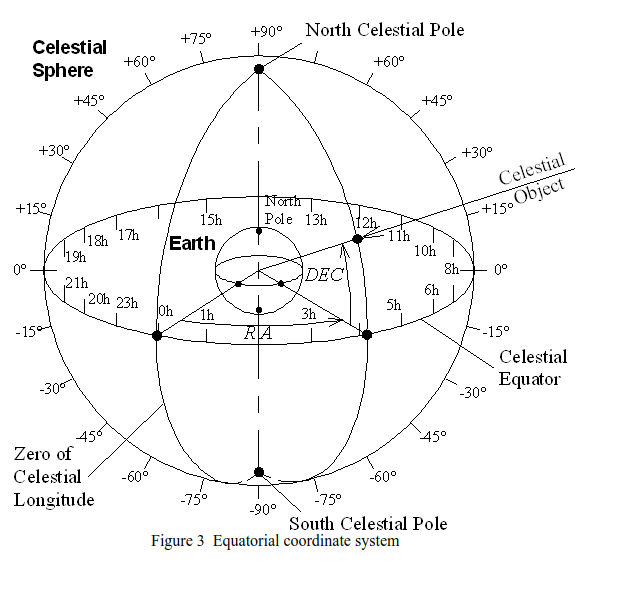

**Σχήμα 3. Σύστημα συντεταγμένων Ορθής αναφοράς - Απόκλισης (Right Ascension, Ra - Declination, Dec).**  Οι δύο γωνίες που χρειαζόμαστε για την περιγραφή ενός ουράνιου αντικειμένου είναι η ορθή αναφορά (Right ascension) και η απόκλιση (declination). Η απόκλιση μετριέται από το ουράνιο ισημερινό επίπεδο προς το βορρά και νότο και μετράται σε μοίρες (-90 μοίρες έως +90 μοίρες). Η ορθή αναφορά είναι γωνία η οποία μετράται από το σημείο της εαρινής ισημερίας (vernal equinox) -- βλέπε σχήμα 2 -- με φορά προς τα ανατολικά. Μετράται σε ώρες (0-24 hr). 1 ώρα (1hr) αντιστοιχεί σε 15 μοίρες. Καθώς η Γη περιστρέφεται τα άστρα, όπως  ο Ήλιος, φαίνονται κινούνται στον ουρανό. Ανατέλλουν στην Ανατολή και δύουν στη Δύση. Η ορθή αναφορά περιγράφει πόσο αργότερα σε σχέση με τον Ήλιο θα εμφανιστεί στον ουρανό ένα αντικείμενο κατά την εαρινή ισημερία (~20 Μαρτίου). Π.χ. ένα άστρο με Ra = 4 hr, θα ανατείλλει μετά από 4 ώρες από την ανατολή του Ήλιου. 

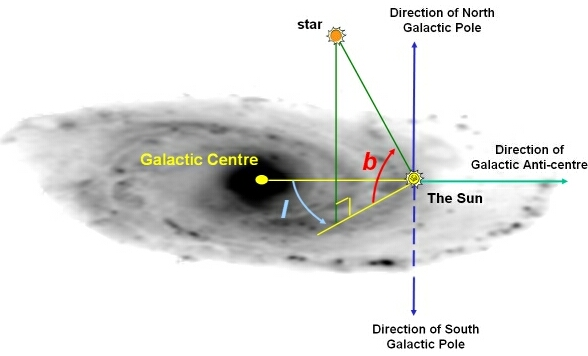

**Σχήμα 4. Σύστημα γαλαξιακών συντεταγμένων (Γαλαξιακό μήκος, l - Γαλαξιακό πλάτος, b).** Χρησιμοποιούνται για τον προσδιορισμό θέσης αντικειμένων στο Γαλαξία σε σχέση με τη Γη. Ο Ήλιος βρίσκεται στην αρχή των αξόνων. Υπάρχουν επίσης δύο κύριες κατευθύνσεις: η πρώτη είναι αυτή προς το Γαλαξιακό κέντρο και η δεύτερη είναι κάθετη στο γαλαξιακό ισημερινό επίπεδο. Η θέση ενός αντικειμένου στο σύστημα αυτό περιγράφεται από δύο γωνίες. Το γαλαξιακό πλάτος (galactic latitude, b) μετράται από το γαλαξιακό επίπεδο προς τους γαλαξιακούς πόλους (-90 μοίρες έως +90 μοίρες). Το γαλαξιακό μήκος (galactic longitude, l) μετράται στο γαλαξιακό επίπεδο ξεκινώντας από τη νοητή ευθεία που συνδέει τον Ήλιο με το γαλαξιακό κέντρο (0-360 μοίρες). 

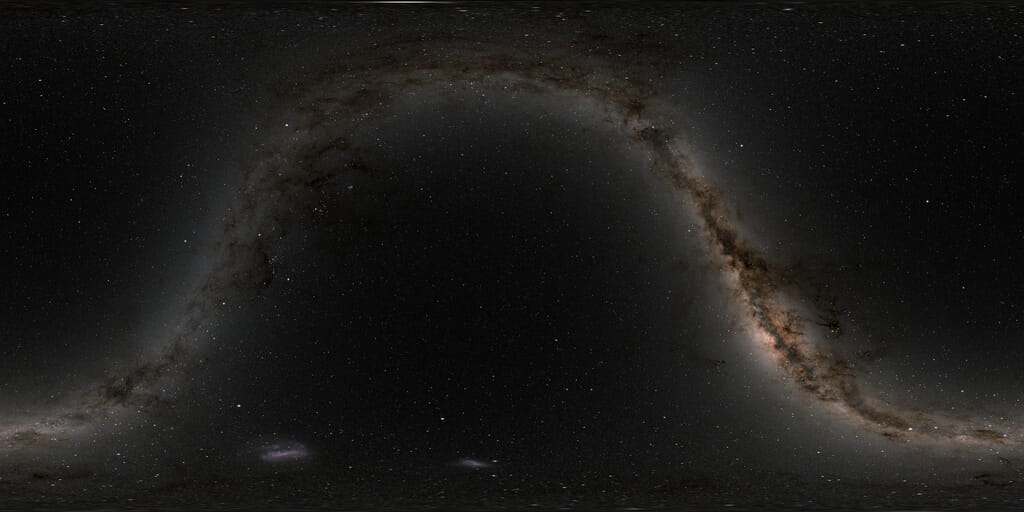

**Σχήμα 5.** Εικόνα του Γαλαξιακού δίσκου και των Νεφών του Μαγγελάνου σε σύστημα ουρανογραφικών συντεταγμένων. Η εικόνα είναι κεντραρισμένη στο Ra = 0h και το Ra αυξάνεται προς τα αριστερά της εικόνας. 

# Απεικόνιση θέσης αστεριών 

Για τους πλανήτες και τα φεγγάρια τους, το Jet Propulsion Laboratory (JPL) της NASA προσφέρει πίνακες θέσεων υψηλής ακρίβειας για χρονικά διαστήματα που κυμαίνονται από δεκαετίες έως αιώνες. Κάθε πίνακας ονομάζεται *εφημερίδα*, από την αρχαία ελληνική λέξη *εφήμερις*. Φορτώνουμε την εφημερίδα  JPL DE421 (1900-2050).

In [2]:
# load celestial data

# de421 shows position of earth and sun in space
eph = load('de421.bsp')

Φόρτωση δεδομένων από την αποστολή της ESA Ίππαρχος. https://www.esa.int/Science_Exploration/Space_Science/Hipparcos_overview

In [3]:
# hipparcos dataset contains star location data
with load.open(hipparcos.URL) as f:
    stars = hipparcos.load_dataframe(f)

Φόρτωση αστερισμών από αρχείο. Προσοχή! Δουλεύει μόνο για άστρα του καταλόγου Ίππαρχου.

In [4]:
# constellation membership for the specific hipparchos catalog. 
# script assigns membership to stars and stores indices in "constellationship.fab" file.
# thus it only works with specific catalog loaded above
#https://github.com/Stellarium/stellarium/tree/master/skycultures/modern_st

url = ('https://raw.githubusercontent.com/Stellarium/stellarium/master'
           '/skycultures/modern_st/constellationship.fab')

with load.open(url) as f:
    constellations = stellarium.parse_constellations(f)
    
edges = [edge for name, edges in constellations for edge in edges]
edges_star1 = [star1 for star1, star2 in edges]
edges_star2 = [star2 for star1, star2 in edges]


In [5]:
# set location
location = 'Athens, GReece'
# set date and time
when = '2024-03-11 00:00'
# set latitude and longitude of our location 
lat, long = 37.983810, 23.727539

# alternative you can get the altitude of your location using GPS tracker -- requires VPN access to UOA.
# locator = Nominatim(user_agent='myGeocoder')
# location = locator.geocode(location)


# convert date string into datetime object
dt = datetime.strptime(when, '%Y-%m-%d %H:%M')

# define datetime and convert to utc based on our timezone
timezone_str = tzwhere.tzwhere().tzNameAt(lat, long)
local = timezone(timezone_str)

# get UTC from local timezone and datetime
local_dt = local.localize(dt, is_dst=None)
utc_dt = local_dt.astimezone(utc)

/utils/Conda/anaconda3/envs/astro3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [6]:
# find location of earth and sun and set the observer position
sun = eph['sun']
earth = eph['earth']

# define observation time from our UTC datetime
ts = load.timescale()
t = ts.from_datetime(utc_dt)


# define an observer using the world geodetic system data
observer = wgs84.latlon(latitude_degrees=lat, longitude_degrees=long).at(t)

# define the position in the sky where we will be looking
# example observer looking at zenith from a specific location at a specific time
position = observer.from_altaz(alt_degrees=90, az_degrees=0) 

In [7]:
# center the observation point in the middle of the sky
ra, dec, distance = observer.radec()
center_object = Star(ra=ra, dec=dec)

# find where our center object is relative to earth and build a projection with 180 degree view
center = earth.at(t).observe(center_object)
projection = build_stereographic_projection(center)
field_of_view_degrees = 180.0

# calculate star positions and project them onto a plane 
star_positions = earth.at(t).observe(Star.from_dataframe(stars))
stars['x'], stars['y'] = projection(star_positions)

In [8]:
# define edges for constellations based on projected star positions for given location and time
xy1 = stars[['x', 'y']].loc[edges_star1].values
xy2 = stars[['x', 'y']].loc[edges_star2].values
lines_xy = np.rollaxis(np.array([xy1, xy2]), 1)

In [9]:
# select bright starts for display
limiting_magnitude = 10 #apparent magnitude  
bright_stars = (stars.magnitude <= limiting_magnitude) 
magnitude = stars['magnitude'][bright_stars]

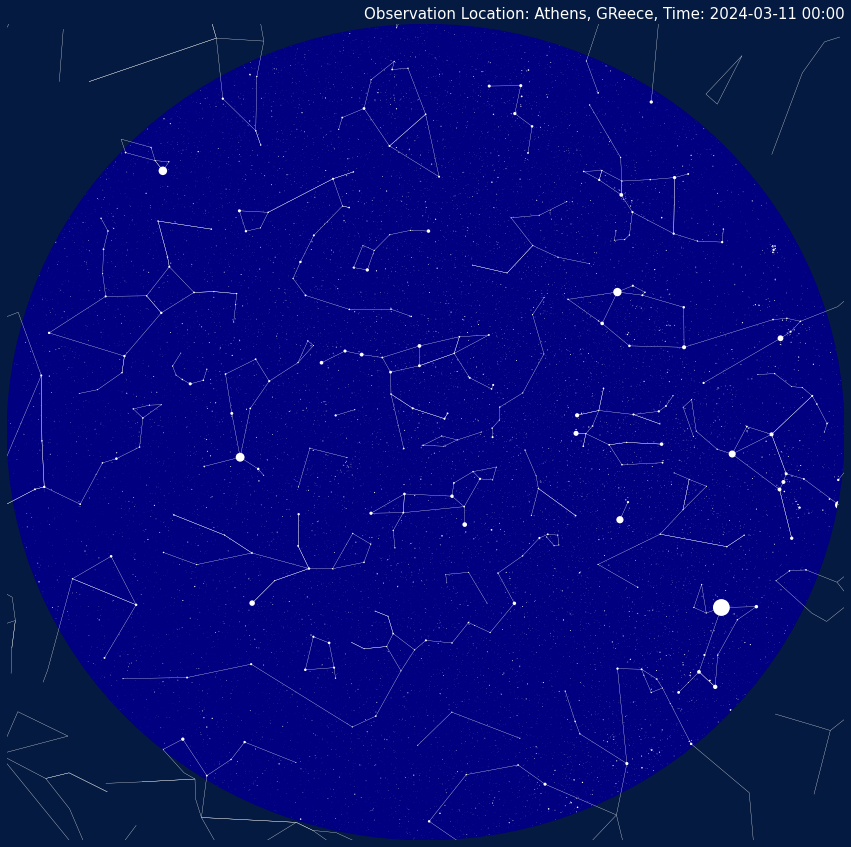

In [10]:
# plot the stars on the sky
chart_size = 15
# fig, ax = plt.subplots(figsize=(chart_size, chart_size))

fig, ax = plt.subplots(figsize=(chart_size, chart_size),facecolor='#041A40')
border = plt.Circle((0, 0), 1, color='navy', fill=True)
ax.add_patch(border)


max_star_size = 300
marker_size = max_star_size * 10 ** (magnitude / -2.5)

ax.scatter(stars['x'][bright_stars], stars['y'][bright_stars],
           s=marker_size, color='white', marker='.', linewidths=0, 
           zorder=2)

horizon = Circle((0, 0), radius=1, transform=ax.transData)
for col in ax.collections:
    col.set_clip_path(horizon)

# if you want to overlay constellations on top of stars selected from Hipparchos catalog.     
ax.add_collection(LineCollection(lines_xy, colors='#ffff', linewidths=0.3))

# other settings
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
plt.axis('off')

when_datetime = datetime.strptime(when, '%Y-%m-%d %H:%M')
plt.title(f"Observation Location: {location}, Time: {when_datetime.strftime('%Y-%m-%d %H:%M')}", loc='right',color = 'white', fontsize=15)
filename = f"{location}_{when_datetime.strftime('%Y%m%d_%H%M')}.png"
#plt.savefig(filename, format='png', dpi=1200)

# plt.show()

# Ασκήσεις (προαιρετικές)

1. Σώστε εικόνες του ουρανό όπως φαίνεται από την Αθήνα για ένα 24ωρο. Προσπαθήστε να φτιάξετε μια κινούμενη εικόνα (animated figure). Υπόδειξη: συνάρτηση ή/και χρήση loop για δημιουργία και σώσιμο εικόνων. 
2. Πώς θα φαινόταν o ουρανός σήμερα από το Cape Town; Θα βλέπαμε κοινούς αστερισμούς; 
3. Σε ποιο γεωγραφικό πλάτος θα έπρεπε να βρεθούμε ώστε να μην έχουμε κοινούς αστερισμούς με την Αθήνα;